# Autoencoders for Anomaly Detection

We build an autoencoder to detect potential fraud on credit card data. 
We use an open-source dataset that is available on Kaggle. It has been "cleaned" and stripped of personally identifiable information.

## Imports

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


## The data

The dataset can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It refers to credit card transactions occurred over two days, with 492 fraudulent ones out of 284,807.

All variables in the dataset are numerical. The data has been "obscured" using a PCA transofrmation for regulatory reasons. The two features that haven't changed are Time and Amount. Time is measured in seconds elapsed between each transaction and the first transaction in the dataset.

In [3]:
df = pd.read_csv("data/creditcard.csv")

## Visualization

In [4]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. There are no missing values.

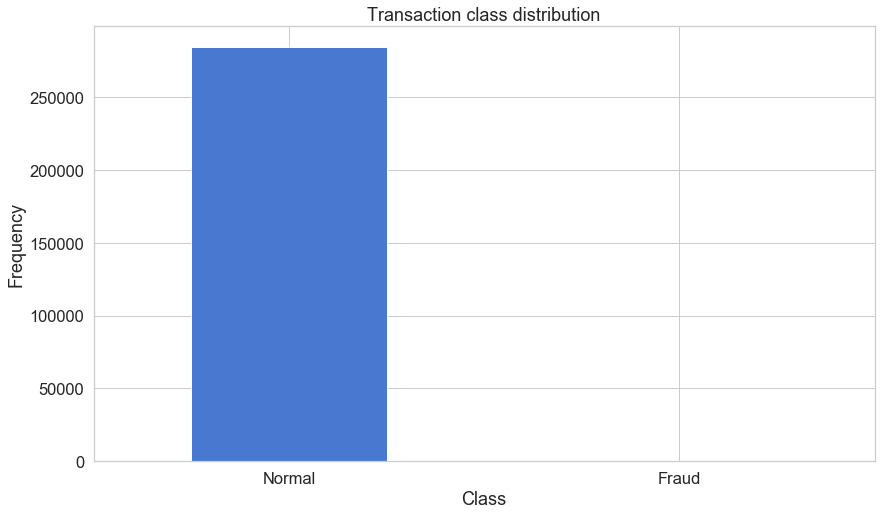

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

The dataset is highly imbalanced. That is to be expected: we are looking for anomalies and those are by definition rare. It would be really problematic if fraud was a significant percentage of the transactions!

In [43]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [44]:
frauds.shape

(492, 31)

In [45]:
normal.shape

(284315, 31)

In [9]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [10]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

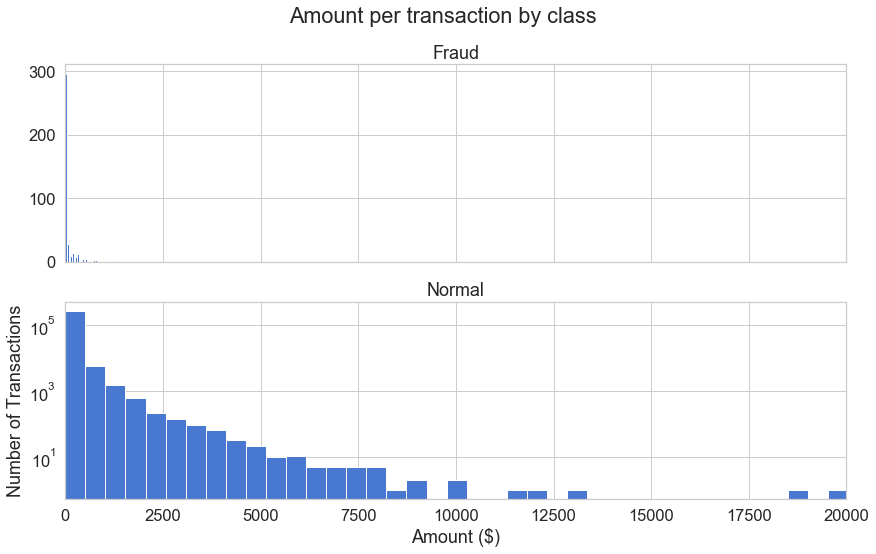

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

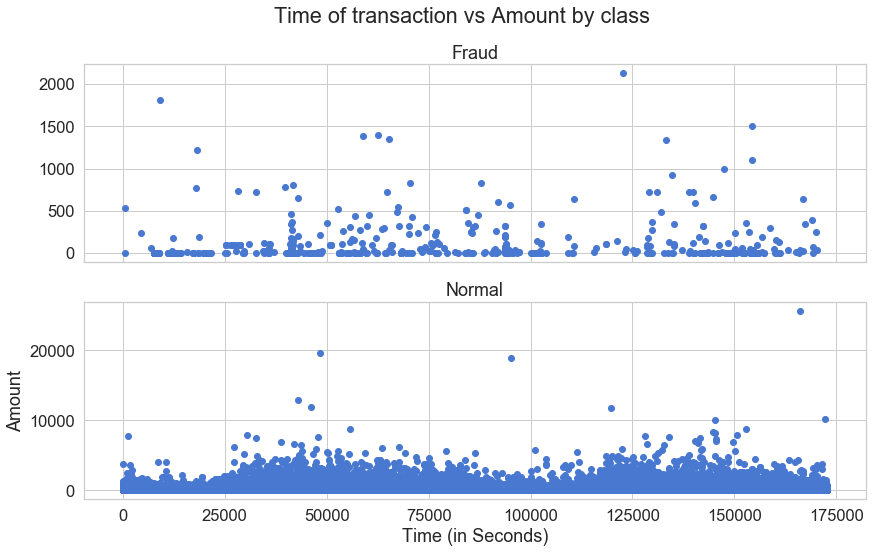

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

It looks like fraudulent transactions tend to be for small amounts, and time doesn't seem to matter.

## Autoencoders

We want to build an undercomplete autoencoder that learns the characteristics  of a normal transaction.

## Reconstruction error

We optimize its parameters to minimize the reconstruction error, which in this case we'll measure with MSE.

## Data preparation

Time does not seem important, so we'll drop it. We'll also normalize the amount to unit variance in order to limit bias. 

In [13]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

We split the data set 80/20% and select normal transactions (class=0), because we want the autoencoder to learn that representation only.
We also drop the class value, because the autoencoder is unsupervised.

In [14]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [15]:
X_train.shape

(227451, 29)

## Building the model

We use 4 fully connected layers with 14, 7, 7 and 29 neurons respectively.  The first two layers are used for the encoder, the last two for the decoder. L1 regularization will be used during training:

In [16]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [17]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

We train the model for 100 epochs with a batch size of 32 samples and save the best to a file using a checkpoint callback. We also log values at each iteration for Tensorboard to display.

In [48]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mse', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 16s 68us/step - loss: 0.7802 - acc: 0.6208 - val_loss: 0.7786 - val_acc: 0.6365
Epoch 2/100
227451/227451 [==============================] - 15s 66us/step - loss: 0.7422 - acc: 0.6505 - val_loss: 0.7700 - val_acc: 0.6541
Epoch 3/100
227451/227451 [==============================] - 15s 66us/step - loss: 0.7382 - acc: 0.6544 - val_loss: 0.7744 - val_acc: 0.6541
Epoch 4/100
227451/227451 [==============================] - 15s 67us/step - loss: 0.7367 - acc: 0.6558 - val_loss: 0.7697 - val_acc: 0.6546
Epoch 5/100
227451/227451 [==============================] - 16s 68us/step - loss: 0.7364 - acc: 0.6556 - val_loss: 0.7673 - val_acc: 0.6608
Epoch 6/100
227451/227451 [==============================] - 15s 66us/step - loss: 0.7358 - acc: 0.6557 - val_loss: 0.7638 - val_acc: 0.6523
Epoch 7/100
227451/227451 [==============================] - 15s 66us/step - loss: 0.7315 - acc: 0.6509

KeyboardInterrupt: 

In [19]:
# load the best model back
autoencoder = load_model('model.h5')

## Evaluation

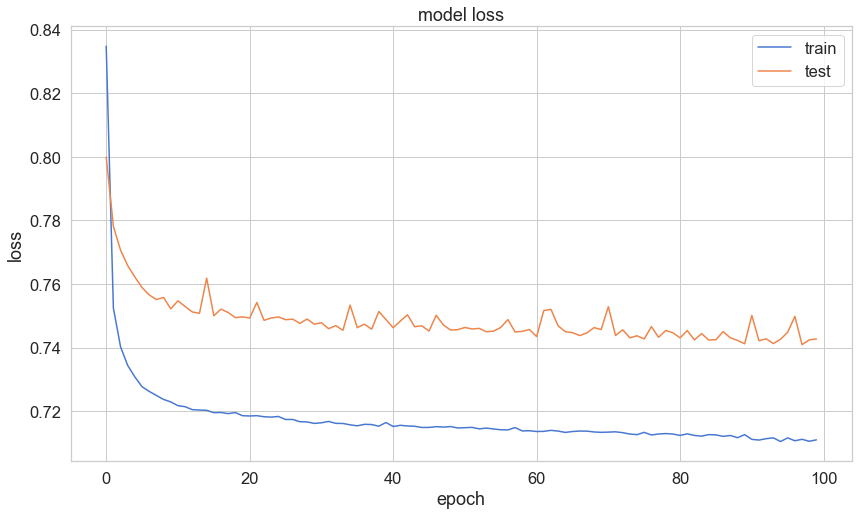

In [20]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [21]:
predictions = autoencoder.predict(X_test)

In [22]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [23]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.731822,0.001720
std,3.357383,0.041443
min,0.043996,0.000000
25%,0.243718,0.000000
50%,0.404623,0.000000
75%,0.639182,0.000000
max,261.230109,1.000000


## Reconstruction error without fraud

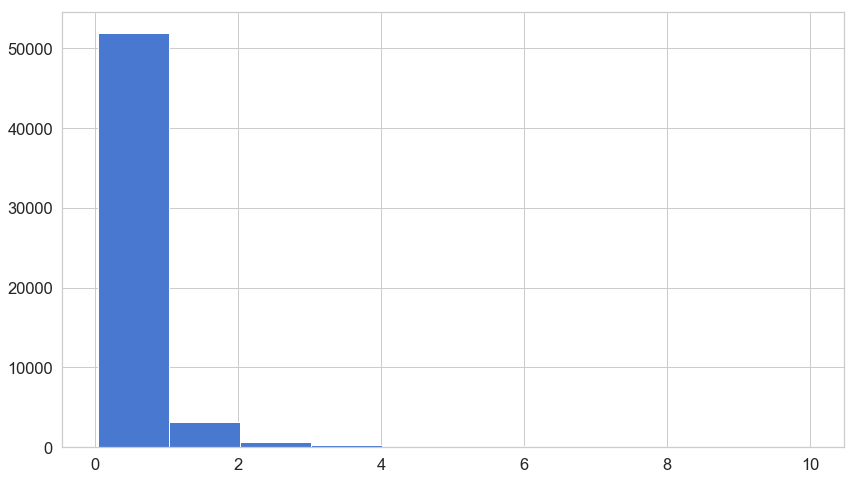

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Reconstruction error with fraud

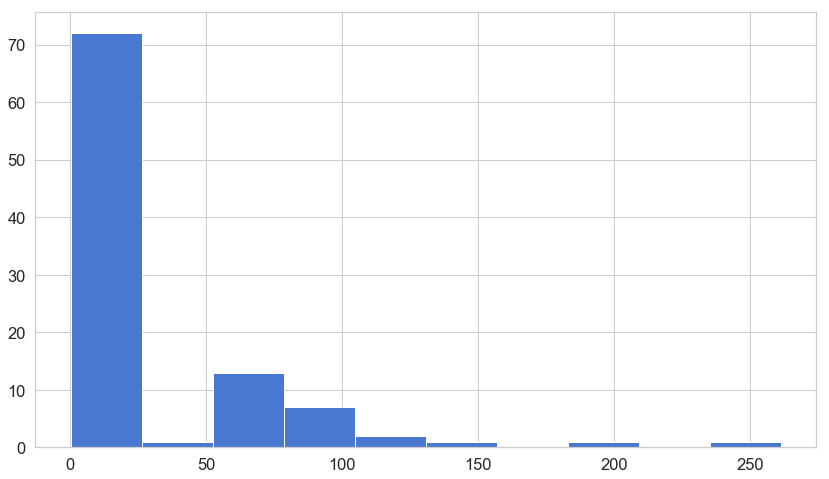

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [26]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are not very useful in the case of anomaly detection, because the dataset is too imbalanced. Nonetheless, let's have a look at our ROC curve:

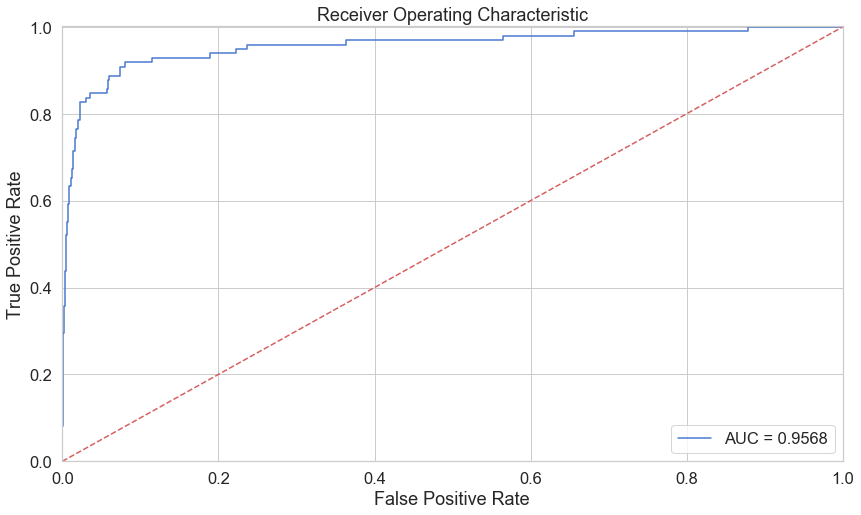

In [27]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

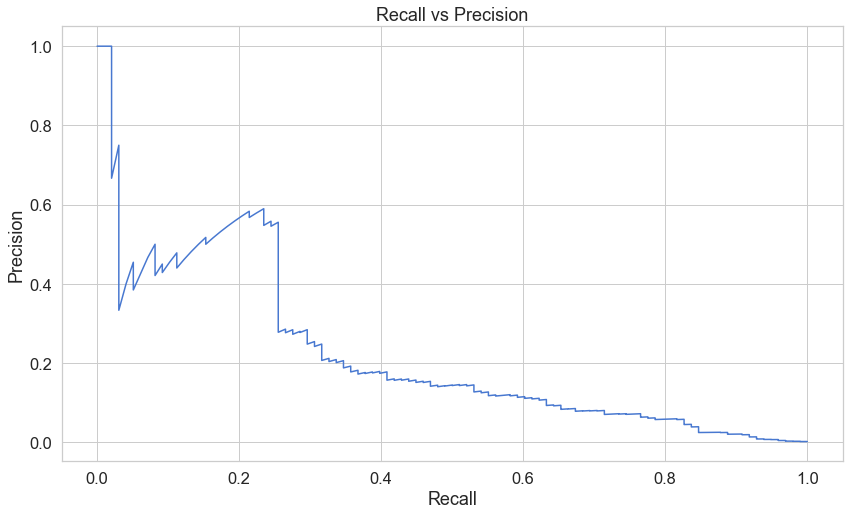

In [28]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

High precision indicates a low false positive rate, high recall a low false negative rate. Ideally we want both.

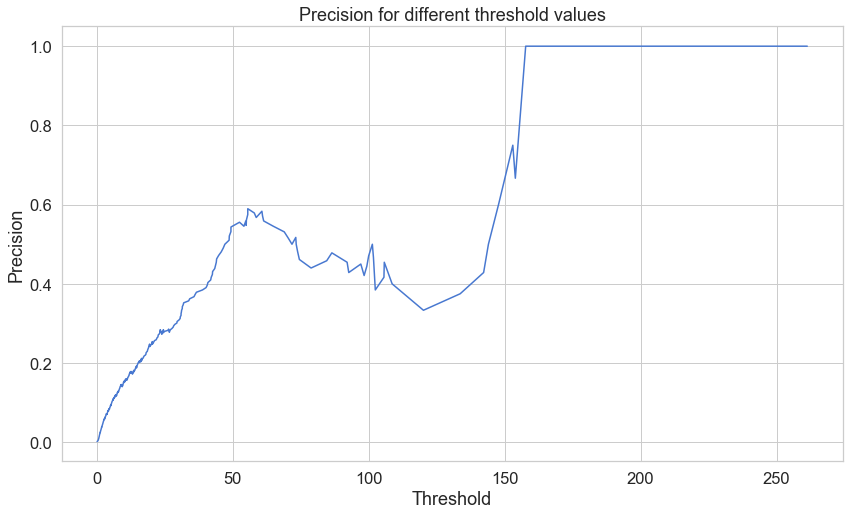

In [29]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

As the reconstruction error increases, precision does as well. 

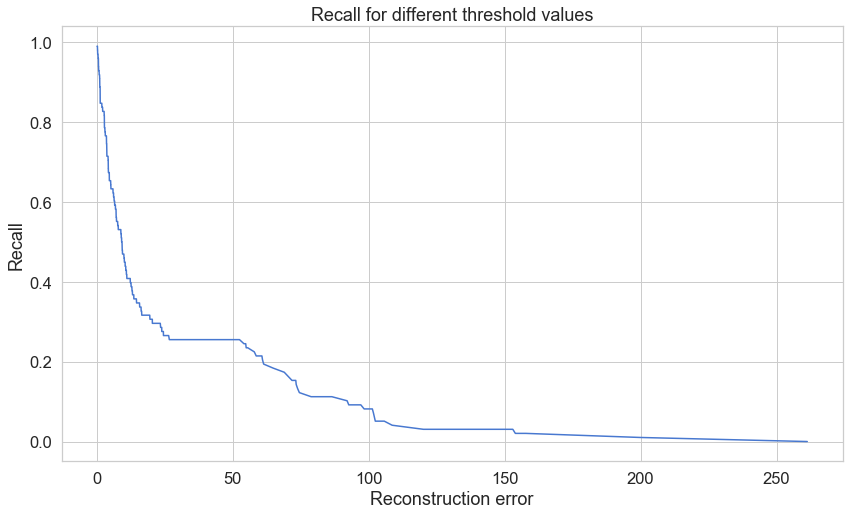

In [30]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

 As the reconstruction error increases, the recall decreases.

## Prediction

An autoencoder does not predict, it just reconstructs. In order to predict whether or not a transaction is normal or fraudulent, we calculate the reconstruction error from the transaction data. If the error is larger than a given threshold, we'll mark it as a fraud. In fact, our model was trained to reconstruct normal transactions. The reconstruction error will be higher for fraudulent ones.

In [40]:
threshold = 4.0

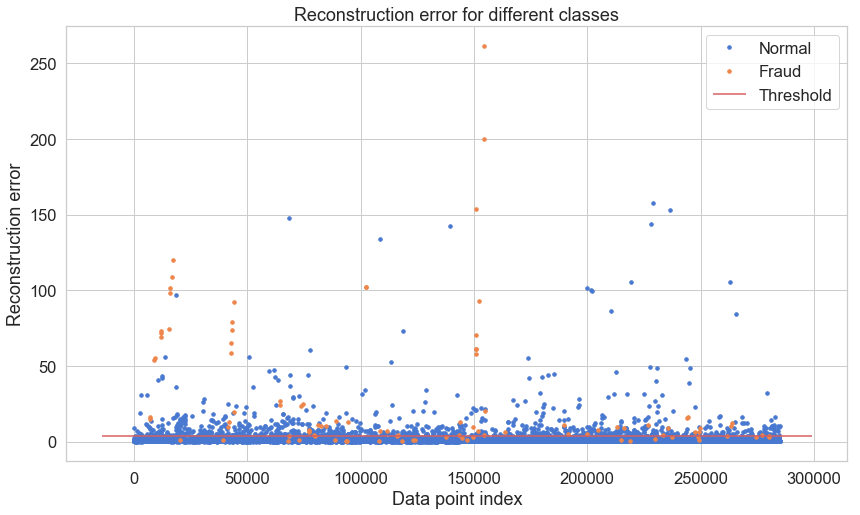

In [41]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

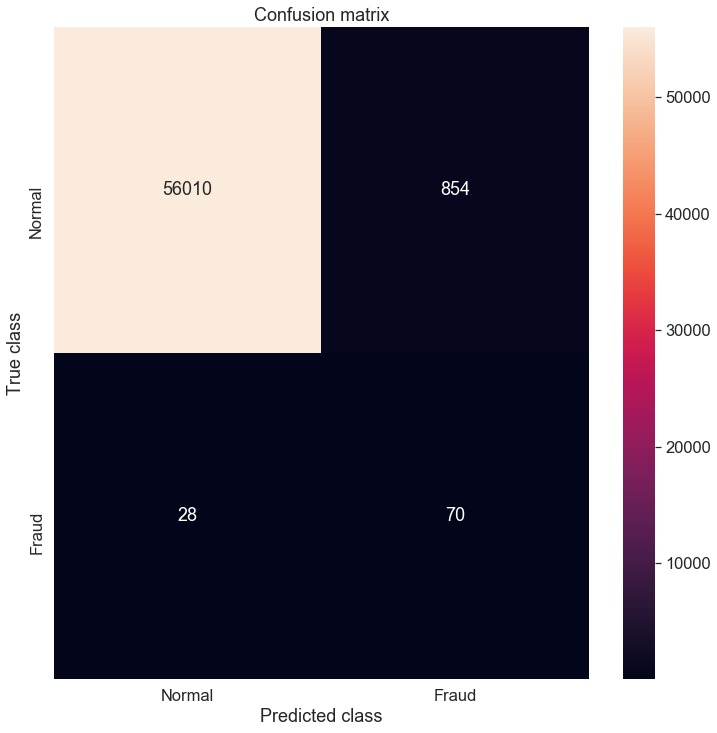

In [42]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Observation
The model still has quite a lot of false positives (i.e. normal transactions that were predicted to be fraudulent. Better safe than sorry, but we can do some more tuning.